
### Alex Net Entropy and Marcenko-Pastur Law

http://math.mit.edu/~edelman/publications/random_matrix_theory_innovative.pdf



This time, I ensure W has norm 1


In [8]:
import numpy as np
import tensorflow as tf
import pickle, time
from copy import deepcopy
from shutil import copy
from tqdm import tqdm_notebook as tqdm
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import sparse_random_matrix
print(sklearn.__version__)

0.19.1


In [9]:
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.optimizers import SGD
from keras.initializers import Constant
import keras.backend as K


model = Sequential()
model.add(Conv2D(96, (5, 5), input_shape=(28, 28, 3), kernel_initializer=
                 'glorot_normal', bias_initializer=Constant(0.1), padding=
                 'same', activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (5, 5), kernel_initializer='glorot_normal',
                 bias_initializer=Constant(0.1), padding='same',
                 activation='relu')) 
model.add(MaxPooling2D((3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(384, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(192, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='relu'))
model.add(Dense(10, kernel_initializer='glorot_normal',
                bias_initializer=Constant(0.1), activation='softmax'))



sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())



### Show how to load the weight matrices

#### We care about layers 7 and 8

In [10]:
!ls weights/cifar10_alexnet.h5

weights/cifar10_alexnet.h5


In [11]:
model.load_weights('weights/cifar10_alexnet.h5')

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 28, 28, 96)        7296      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 10, 10, 96)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 10, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
__________

In [12]:
model.load_weights("weights/cifar10_alexnet.h5")
print(len(model.layers))
for il in [7,8,9]:
    print(il)
    W = model.layers[il].get_weights()[0]
    print(np.linalg.norm(W), np.linalg.matrix_rank(W))
        

10
7
24.322296 384
8
14.838495 192
9
5.8947635 10


### Matrix Entropy

http://www.pnas.org/content/97/18/10101.full


### <font color='red'> ensure W has trace 1 ?


In [13]:
def matrix_entropy(W, n=512):

    W=W/np.trace(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    rank = np.linalg.matrix_rank(W)
    p = sv*sv
    p = p/np.sum(p)
    
    if (rank==1):
        rank=1.000001
    entropy = - np.sum(p*np.log(p)) / np.log(rank) 
    return entropy


### Matrix Entropy as a function of Epoch for a single run

### <font color='red'>NOT AT ALL INTERESTING</font>

In [14]:
!ls weights/alexnet.b16.id1.e*.h5 

weights/alexnet.b16.id1.e0.h5  weights/alexnet.b16.id1.e54.h5
weights/alexnet.b16.id1.e1.h5  weights/alexnet.b16.id1.e55.h5
weights/alexnet.b16.id1.e10.h5 weights/alexnet.b16.id1.e56.h5
weights/alexnet.b16.id1.e11.h5 weights/alexnet.b16.id1.e57.h5
weights/alexnet.b16.id1.e12.h5 weights/alexnet.b16.id1.e58.h5
weights/alexnet.b16.id1.e13.h5 weights/alexnet.b16.id1.e59.h5
weights/alexnet.b16.id1.e14.h5 weights/alexnet.b16.id1.e6.h5
weights/alexnet.b16.id1.e15.h5 weights/alexnet.b16.id1.e60.h5
weights/alexnet.b16.id1.e16.h5 weights/alexnet.b16.id1.e61.h5
weights/alexnet.b16.id1.e17.h5 weights/alexnet.b16.id1.e62.h5
weights/alexnet.b16.id1.e18.h5 weights/alexnet.b16.id1.e63.h5
weights/alexnet.b16.id1.e19.h5 weights/alexnet.b16.id1.e64.h5
weights/alexnet.b16.id1.e2.h5  weights/alexnet.b16.id1.e65.h5
weights/alexnet.b16.id1.e20.h5 weights/alexnet.b16.id1.e66.h5
weights/alexnet.b16.id1.e21.h5 weights/alexnet.b16.id1.e67.h5
weights/alexnet.b16.id1.e22.h5 weights/alexnet.b16.id1.e68.h5
weights/a

In [15]:
run_id = 1
num_epochs = 38
epochs = np.arange(1,num_epochs)

every5_epochs = np.arange(0,num_epochs,5)
every5_epochs = np.append(every5_epochs,37)

run_ids = np.arange(1,11)

In [16]:
entropies_w7, entropies_w8 = [], []
for epoch in epochs:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    print(modelfile)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    W8 = model.layers[8].get_weights()[0]
    entropies_w7.append(matrix_entropy(W7, n=384))
    entropies_w8.append(matrix_entropy(W8, n=192))

weights/alexnet.b16.id1.e1.h5
weights/alexnet.b16.id1.e2.h5
weights/alexnet.b16.id1.e3.h5
weights/alexnet.b16.id1.e4.h5
weights/alexnet.b16.id1.e5.h5
weights/alexnet.b16.id1.e6.h5
weights/alexnet.b16.id1.e7.h5
weights/alexnet.b16.id1.e8.h5
weights/alexnet.b16.id1.e9.h5
weights/alexnet.b16.id1.e10.h5
weights/alexnet.b16.id1.e11.h5
weights/alexnet.b16.id1.e12.h5
weights/alexnet.b16.id1.e13.h5
weights/alexnet.b16.id1.e14.h5
weights/alexnet.b16.id1.e15.h5
weights/alexnet.b16.id1.e16.h5
weights/alexnet.b16.id1.e17.h5
weights/alexnet.b16.id1.e18.h5
weights/alexnet.b16.id1.e19.h5
weights/alexnet.b16.id1.e20.h5
weights/alexnet.b16.id1.e21.h5
weights/alexnet.b16.id1.e22.h5
weights/alexnet.b16.id1.e23.h5
weights/alexnet.b16.id1.e24.h5
weights/alexnet.b16.id1.e25.h5
weights/alexnet.b16.id1.e26.h5
weights/alexnet.b16.id1.e27.h5
weights/alexnet.b16.id1.e28.h5
weights/alexnet.b16.id1.e29.h5
weights/alexnet.b16.id1.e30.h5
weights/alexnet.b16.id1.e31.h5
weights/alexnet.b16.id1.e32.h5
weights/alexnet.b

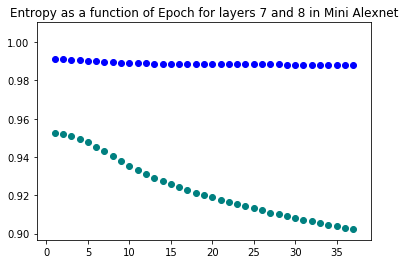

In [17]:
plt.scatter(epochs, entropies_w7, color='blue')
plt.scatter(epochs, entropies_w8, color='teal')
plt.title("Entropy as a function of Epoch for layers 7 and 8 in Mini Alexnet")

In [18]:
!ls weights/alexnet.b16.id1.*

weights/alexnet.b16.id1.101.h5   weights/alexnet.b16.id1.e54.h5
weights/alexnet.b16.id1.e0.h5    weights/alexnet.b16.id1.e55.h5
weights/alexnet.b16.id1.e1.h5    weights/alexnet.b16.id1.e56.h5
weights/alexnet.b16.id1.e10.h5   weights/alexnet.b16.id1.e57.h5
weights/alexnet.b16.id1.e11.h5   weights/alexnet.b16.id1.e58.h5
weights/alexnet.b16.id1.e12.h5   weights/alexnet.b16.id1.e59.h5
weights/alexnet.b16.id1.e13.h5   weights/alexnet.b16.id1.e6.h5
weights/alexnet.b16.id1.e14.h5   weights/alexnet.b16.id1.e60.h5
weights/alexnet.b16.id1.e15.h5   weights/alexnet.b16.id1.e61.h5
weights/alexnet.b16.id1.e16.h5   weights/alexnet.b16.id1.e62.h5
weights/alexnet.b16.id1.e17.h5   weights/alexnet.b16.id1.e63.h5
weights/alexnet.b16.id1.e18.h5   weights/alexnet.b16.id1.e64.h5
weights/alexnet.b16.id1.e19.h5   weights/alexnet.b16.id1.e65.h5
weights/alexnet.b16.id1.e2.h5    weights/alexnet.b16.id1.e66.h5
weights/alexnet.b16.id1.e20.h5   weights/alexnet.b16.id1.e67.h5
weights/alexnet.b16.id1.e21.h5   weights/

## 100 epochs, no early stopping

### Entropy keeps decreasing

In [19]:
epochs100 = np.arange(1,100)
entropies_w7, entropies_w8 = [], []
for epoch in epochs100:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(1,epoch)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    W8 = model.layers[8].get_weights()[0]
    entropies_w7.append(matrix_entropy(W7, n=384))
    entropies_w8.append(matrix_entropy(W8, n=192))

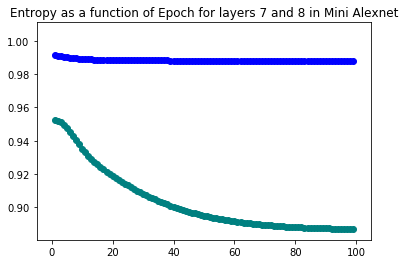

In [20]:
plt.scatter(epochs100, entropies_w7, color='blue')
plt.scatter(epochs100, entropies_w8, color='teal')
plt.title("Entropy as a function of Epoch for layers 7 and 8 in Mini Alexnet")

### training accuracy

the entropy continues to decrease while the training accuracy increases

but the generalization accuracy is slightly worse

In [21]:
! cat results/cifar10_alexnet.b100.100epochs.out | grep "50000/" | head -3

cat: results/cifar10_alexnet.b100.100epochs.out: No such file or directory


In [22]:
accs = np.loadtxt("epochs100.training.accs")
len(accs)

100

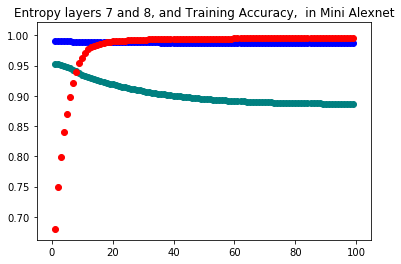

In [23]:
plt.scatter(epochs100, entropies_w7, color='blue')
plt.scatter(epochs100, entropies_w8, color='teal')
plt.scatter(epochs100, accs[1:], color='red')

plt.title("Entropy layers 7 and 8, and Training Accuracy,  in Mini Alexnet")

### Try 1000 epochs...save weights every 10



In [24]:
epochs1000 = np.arange(0,1000,10)
entropies_w7, entropies_w8 = [], []
for epoch in epochs1000:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(1000,epoch)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    W8 = model.layers[8].get_weights()[0]
    entropies_w7.append(matrix_entropy(W7, n=384))
    entropies_w8.append(matrix_entropy(W8, n=192))

In [25]:
!cat results/cifar10_alexnet.id1000.b16.1000epochs.out | grep "50000/" | head -3

50000/50000 [==============================] - 19s 373us/step - loss: 0.0496 - acc: 0.7528


In [26]:
!cat results/cifar10_alexnet.id1000.b16.1000epochs.out  | grep "50000/" | sed -e 's/.*acc://'   > epochs1000.training.accs


In [27]:
accs1000 = np.loadtxt("epochs1000.training.accs")
len(accs1000)

1000

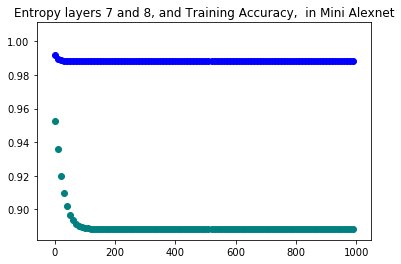

In [28]:
plt.scatter(epochs1000, entropies_w7, color='blue')
plt.scatter(epochs1000, entropies_w8, color='teal')

plt.title("Entropy layers 7 and 8, and Training Accuracy,  in Mini Alexnet")

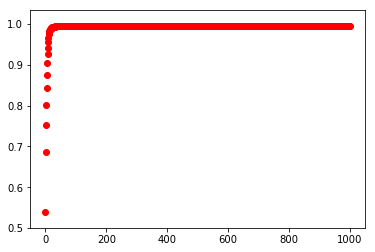

In [29]:
plt.scatter(range(0,1000), accs1000, color='red')


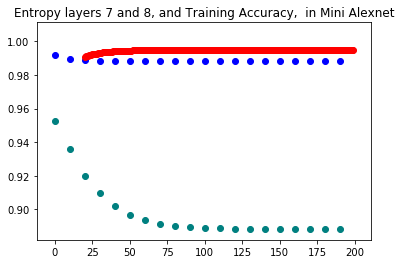

In [30]:
plt.scatter(epochs1000[0:20], entropies_w7[0:20], color='blue')
plt.scatter(epochs1000[0:20], entropies_w8[0:20], color='teal')
plt.scatter(range(20,200), accs1000[20:200], color='red')

plt.title("Entropy layers 7 and 8, and Training Accuracy,  in Mini Alexnet")

## Compute generalization accuracy for 1000 eppchs

In [31]:
!ls -l ../data/cifar-10-batches-py/test_batch

-rw-r--r--@ 1 charlesmartin14  staff  31035526 Mar 30  2009 ../data/cifar-10-batches-py/test_batch


In [32]:
img = tf.placeholder(tf.float32, [28, 28, 3])
norm_image = tf.image.per_image_standardization(img)

print("Loading test images...")
cifar10_test_images = []
cifar10_test_labels = []
test_file = open('../data/cifar-10-batches-py/test_batch', 'rb')
test_dict = pickle.load(test_file, encoding='bytes')

for image, label in zip(test_dict[b'data'], test_dict[b'labels']):
    image_red = np.reshape(image[:1024], (32, 32))[2:-2, 2:-2] / 255.0
    image_red = np.reshape(image_red, (28, 28, 1))
    image_green = np.reshape(image[1024:2048], (32, 32))[2:-2,
                                                            2:-2] / 255.0
    image_green = np.reshape(image_green, (28, 28, 1))
    image_blue = np.reshape(image[2048:3072], (32, 32))[2:-2, 2:-2] / 255.0
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image_blue = np.reshape(image_blue, (28, 28, 1))
    image = np.concatenate([image_red, image_green, image_blue], axis=-1)
    image = norm_image.eval(feed_dict={img:image})
    cifar10_test_images.append(image)
    label = np.identity(10)[label]
    cifar10_test_labels.append(label)
test_file.close()

Loading test images...


In [33]:
opt = SGD(lr=0.01, momentum=0.9)
model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())


In [34]:
gen_accs = []
for epoch in epochs1000[0:20]:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(1000,epoch)
    model.load_weights(modelfile)
    acc =  model.evaluate(np.array(cifar10_test_images),np.array(cifar10_test_labels), batch_size=256)
    gen_accs.append(acc[1])

10000/10000 [==============================] - 20s 2ms/step


In [48]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 5,5

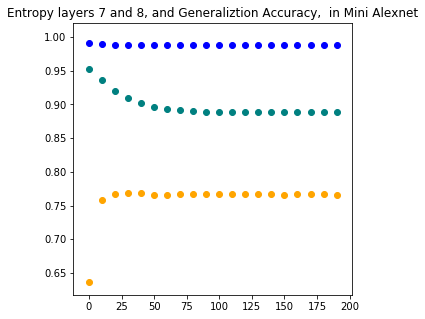

In [49]:
plt.scatter(epochs1000[0:20], entropies_w7[0:20], color='blue')
plt.scatter(epochs1000[0:20], entropies_w8[0:20], color='teal')
plt.scatter(epochs1000[0:20], gen_accs[0:20], color='orange')

plt.title("Entropy layers 7 and 8, and Generaliztion Accuracy,  in Mini Alexnet")

In [50]:
!ls weights/alexnet.b16.id*.e35.h5 

weights/alexnet.b16.id1.e35.h5 weights/alexnet.b16.id3.e35.h5
weights/alexnet.b16.id2.e35.h5


In [51]:
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 16, 16

### Analyze upto 100, not just 37

0 0 0 weights/alexnet.b16.id1.e1.h5
1 0 1 weights/alexnet.b16.id1.e6.h5
2 0 2 weights/alexnet.b16.id1.e11.h5
3 0 3 weights/alexnet.b16.id1.e16.h5
4 0 4 weights/alexnet.b16.id1.e21.h5
5 1 0 weights/alexnet.b16.id1.e26.h5
6 1 1 weights/alexnet.b16.id1.e31.h5
7 1 2 weights/alexnet.b16.id1.e36.h5
8 1 3 weights/alexnet.b16.id1.e41.h5
9 1 4 weights/alexnet.b16.id1.e46.h5
10 2 0 weights/alexnet.b16.id1.e51.h5
11 2 1 weights/alexnet.b16.id1.e56.h5
12 2 2 weights/alexnet.b16.id1.e61.h5
13 2 3 weights/alexnet.b16.id1.e66.h5
14 2 4 weights/alexnet.b16.id1.e71.h5
15 3 0 weights/alexnet.b16.id1.e76.h5
16 3 1 weights/alexnet.b16.id1.e81.h5
17 3 2 weights/alexnet.b16.id1.e86.h5
18 3 3 weights/alexnet.b16.id1.e91.h5
19 3 4 weights/alexnet.b16.id1.e96.h5


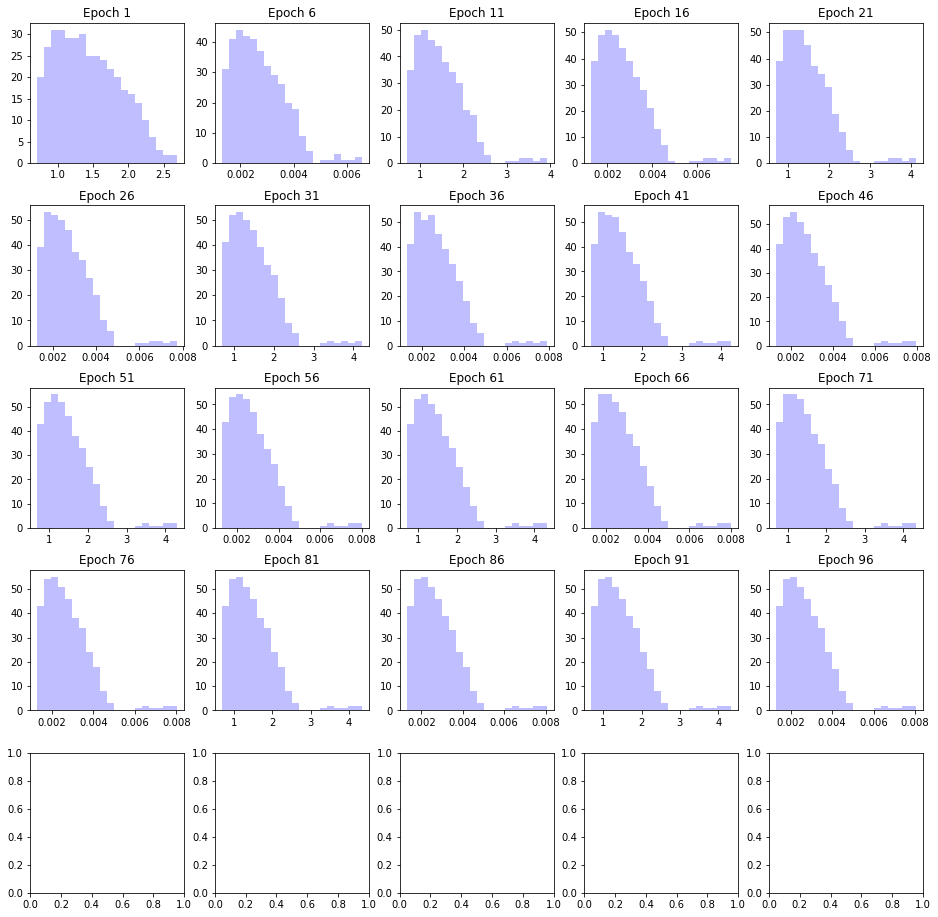

In [52]:
f, axes = plt.subplots(5,5)

for idx, epoch in enumerate(np.arange(1,100,5)):
    eigenvalues = []
    
    #for run_id in [1]:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    n=384
    W = W7 / np.linalg.norm(W)
    svd = TruncatedSVD(n_components=n-1, n_iter=7, random_state=10)
    svd.fit(W) 
    sv = svd.singular_values_
    eigenvalues.append(sv*sv)

    iay = idx % 5
    iax = int(idx / 5)

    print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='blue');
    subplot.set_title("Epoch {}".format(epoch));

    
f.subplots_adjust(hspace=0.3)
plt.show()

fig = plt.figure()

fig.savefig('alexnet_entropy_w7.png')


0 0 0 weights/alexnet.b16.id1.e1.h5
1 0 1 weights/alexnet.b16.id1.e6.h5
2 0 2 weights/alexnet.b16.id1.e11.h5
3 0 3 weights/alexnet.b16.id1.e16.h5
4 0 4 weights/alexnet.b16.id1.e21.h5
5 1 0 weights/alexnet.b16.id1.e26.h5
6 1 1 weights/alexnet.b16.id1.e31.h5
7 1 2 weights/alexnet.b16.id1.e36.h5
8 1 3 weights/alexnet.b16.id1.e41.h5
9 1 4 weights/alexnet.b16.id1.e46.h5
10 2 0 weights/alexnet.b16.id1.e51.h5
11 2 1 weights/alexnet.b16.id1.e56.h5
12 2 2 weights/alexnet.b16.id1.e61.h5
13 2 3 weights/alexnet.b16.id1.e66.h5
14 2 4 weights/alexnet.b16.id1.e71.h5
15 3 0 weights/alexnet.b16.id1.e76.h5
16 3 1 weights/alexnet.b16.id1.e81.h5
17 3 2 weights/alexnet.b16.id1.e86.h5
18 3 3 weights/alexnet.b16.id1.e91.h5
19 3 4 weights/alexnet.b16.id1.e96.h5


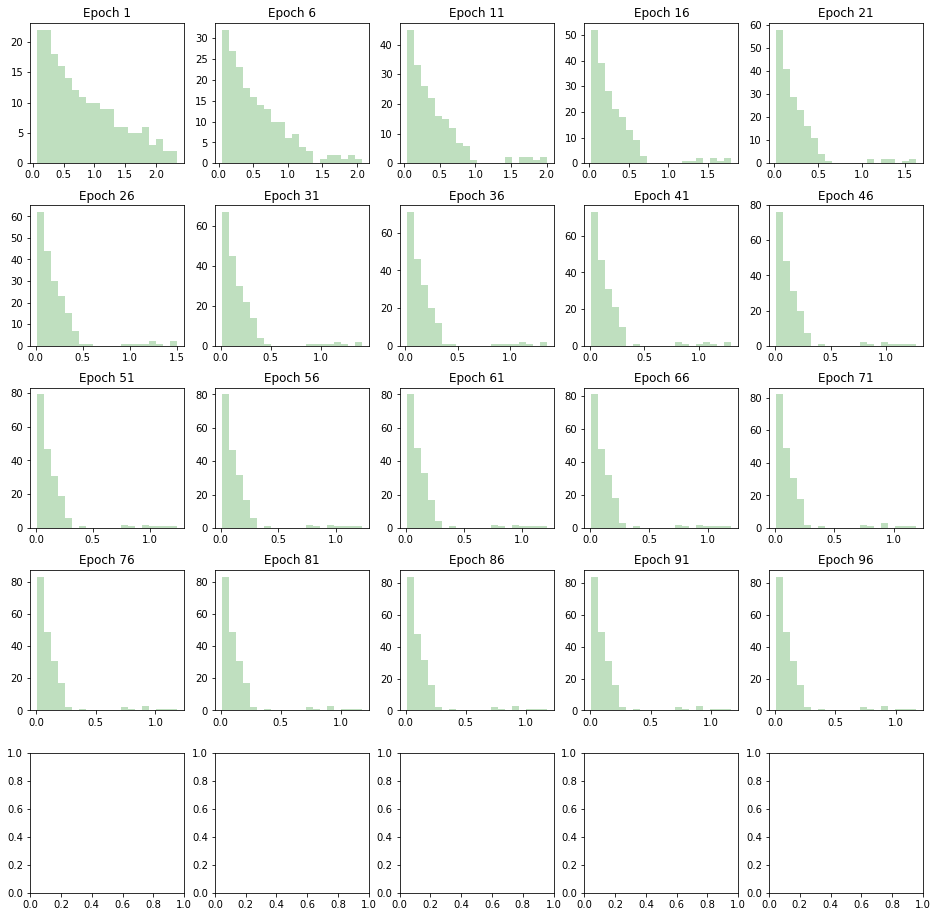

In [53]:
f, axes = plt.subplots(5, 5)

for idx, epoch in enumerate(np.arange(1,100,5)):
    eigenvalues = []
    
    #for run_id in [1]:
    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(run_id,epoch)
    model.load_weights(modelfile)
    W8 = model.layers[8].get_weights()[0]
    n=192
    WW = np.dot(W8.transpose(),W8)
    #WW = / np.linalg.norm(WW)
    
    ev, _ = np.linalg.eig(WW)
    eigenvalues.append(ev)

    iay = idx % 5
    iax = int(idx / 5)

    print(idx, iax, iay, modelfile)
    subplot = axes[iax,iay]
    subplot.hist(eigenvalues, bins=20, alpha=0.25, color='green');
    subplot.set_title("Epoch {}".format(epoch));

    
f.subplots_adjust(hspace=0.3)
fig = plt.figure()

fig.savefig('alexnet_entropy_w8.png')
plt.show()


### save file 

### TODO

- make this into a 3d Plot
- average over all ids
- repeat for MLP3
- 

 
### Fit Marchecnko-Pastur
  
  - get working on the fits I have
  - can we shuffle the elements and obtain MP

## Numerical fitting 
pyRMT.py


In [54]:
### What does AlexNet look like after 100 iterations ?

In [55]:
modelfiles = ["alexnet.b16.id2.final.h5" ]
colors = ["green", "blue"]

In [56]:
modelfiles = ["cifar10_alexnet.h5", "alexnet.b2.final.h5", "cifar10_alexnet_wd.h5","cifar10_alexnet_rand_labels.h5", "alexnet.b512.final.h5" ,"alexnet.b16.rand100.final.h5", "alexnet.b2.rand100.final.h5"]
colors = ["green", "blue", "red", "orange", "cyan", "blue", "magenta"]

In [57]:
modelfiles = ["alexnet.b16.id1.e1.h5" ]
colors = ["blue"]

alexnet.b16.id1.e1.h5


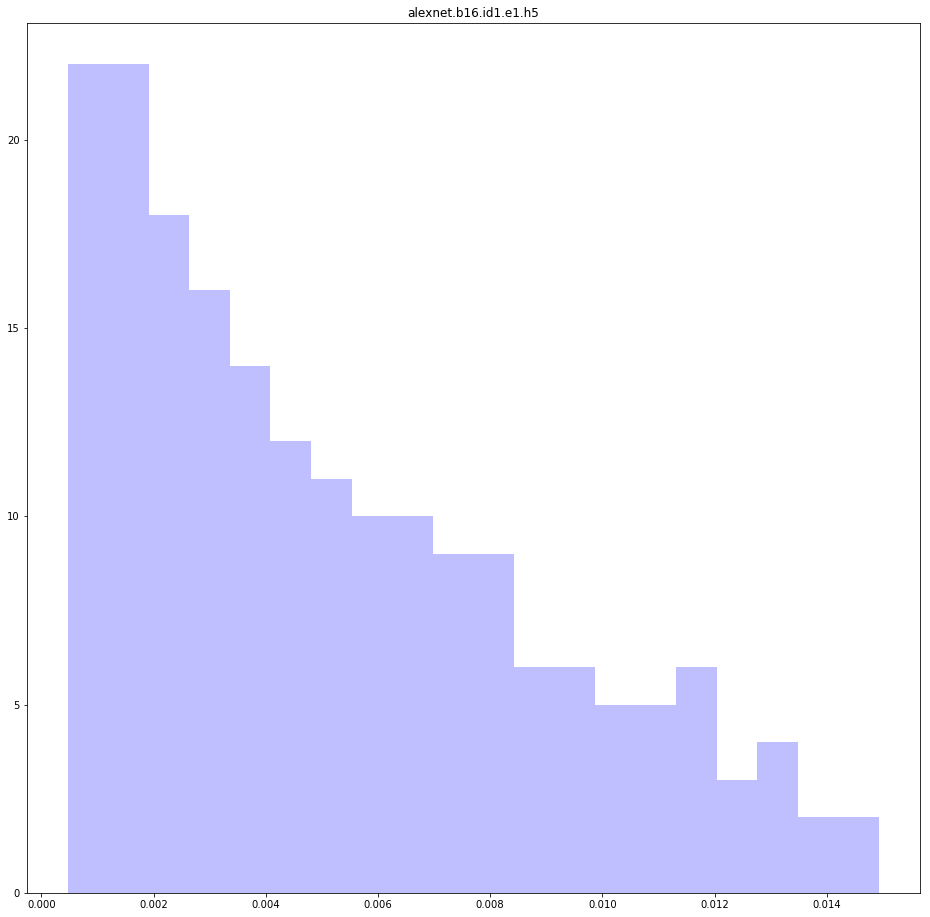

In [58]:
for modelfile, color in zip(modelfiles, colors):
    print(modelfile)
    model.load_weights("weights/{}".format(modelfile))
    W7 = model.layers[8].get_weights()[0]
    n = 384
    W = W7 / np.linalg.norm(W7)
    WW = np.dot(W.transpose(),W)
    ev, _ = np.linalg.eig(WW)


    plt.hist(ev, bins=20, alpha=0.25, color=color);
    plt.title(modelfile)
    plt.show()

### Analyis of final 100 runs

alexnet.b16.id1xx.final

In [121]:
def alexnet_eigenvalues(idstart=100, numids=100, batch_size=16, rand=False):
    ev7s, ev8s = [], []
    for idx in range(idstart,idstart+numids):
        modelfile = "weights/alexnet.b{}.id{}.final.h5".format(batch_size,idx)
        if rand:
             modelfile = "weights/alexnet.b{}.rand100.id{}.final.h5".format(batch_size,idx)
        
        model.load_weights(modelfile)
        
        W7 = model.layers[7].get_weights()[0]
        n = 384
        W = W7 / np.linalg.norm(W7)
        WW = np.dot(W.transpose(),W)
        ev, _ = np.linalg.eig(WW)
        ev7s.extend(ev)

        W8 = model.layers[8].get_weights()[0]
        n = 192
        W = W8 / np.linalg.norm(W8)
        WW = np.dot(W.transpose(),W)
        ev, _ = np.linalg.eig(WW)
        ev8s.extend(ev)
        
    return ev7s, ev8s

In [60]:
numids = 100
batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(numids=numids, batch_size=batch_size)

In [61]:
len(ev7s), len(ev8s)

(38400, 19200)

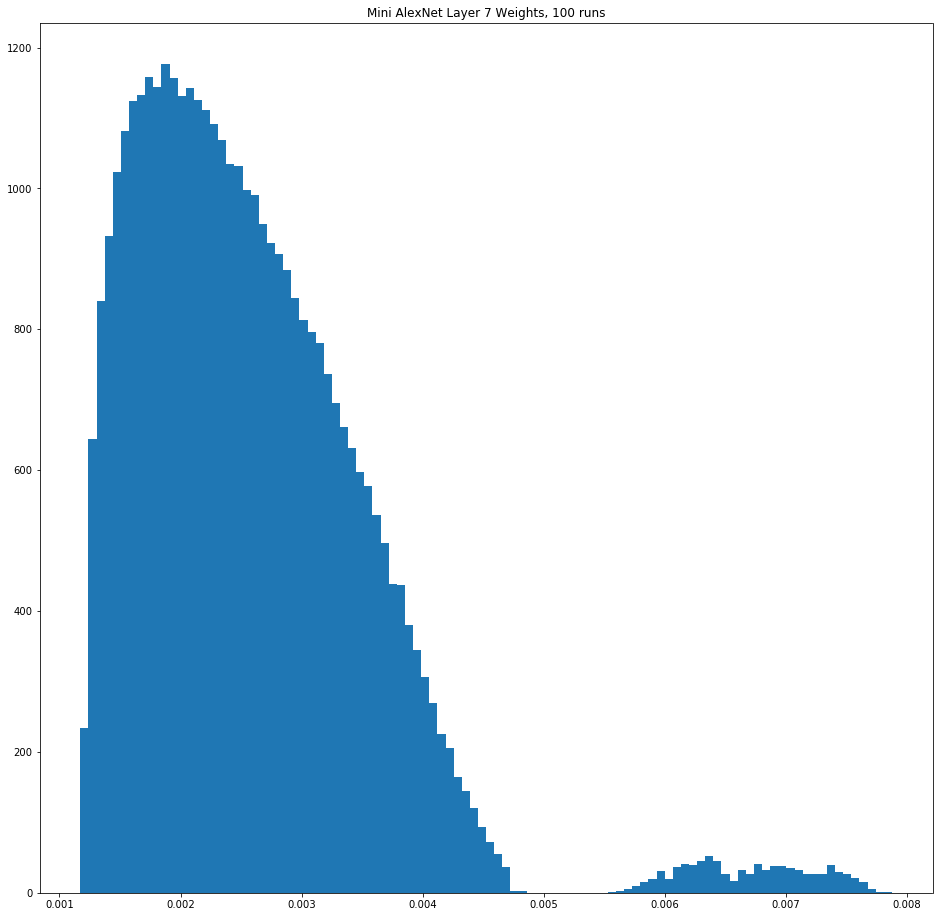

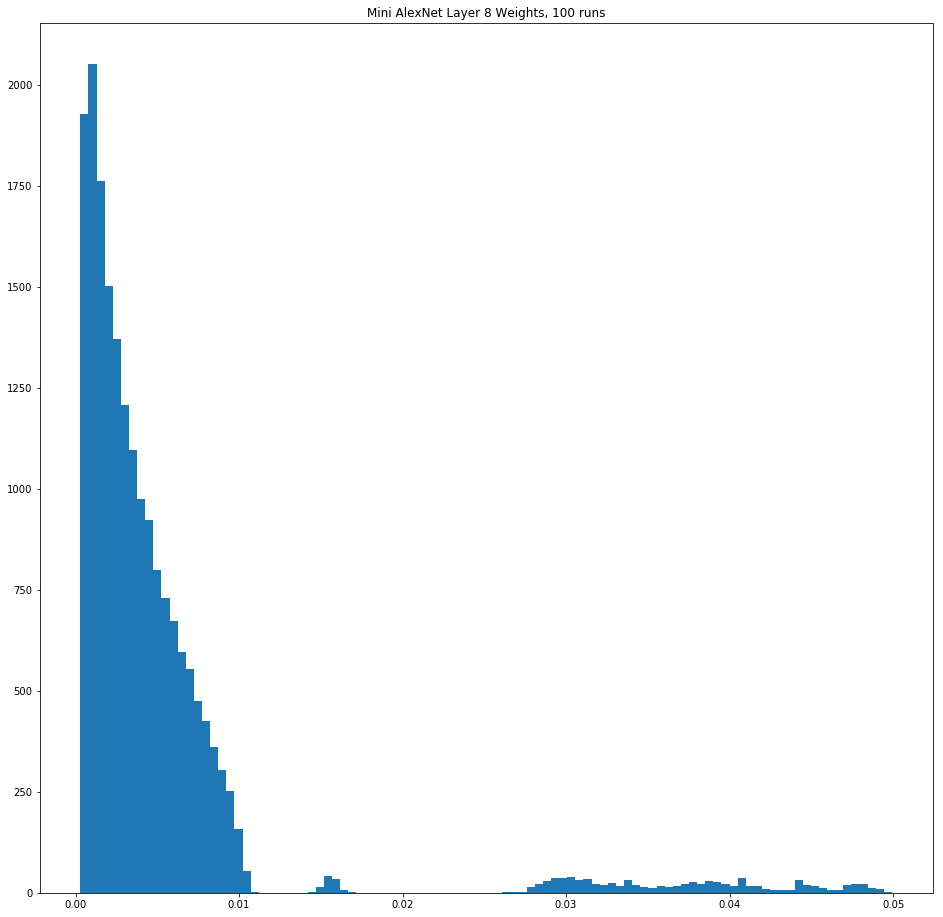

In [62]:
plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet Layer 7 Weights, 100 runs")
plt.show()
plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet Layer 8 Weights, 100 runs")
plt.show()

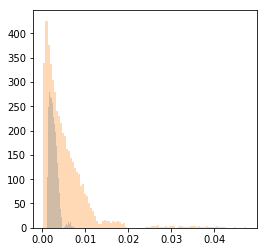

In [94]:
plt.hist(ev7s, bins=100, alpha=0.3);
plt.hist(ev8s, bins=100, alpha=0.3);

### other

- random labels  (75 runs, doable)
- smaller / larger batch size  (b2, b50, b100, b250: 10 runs or more available)


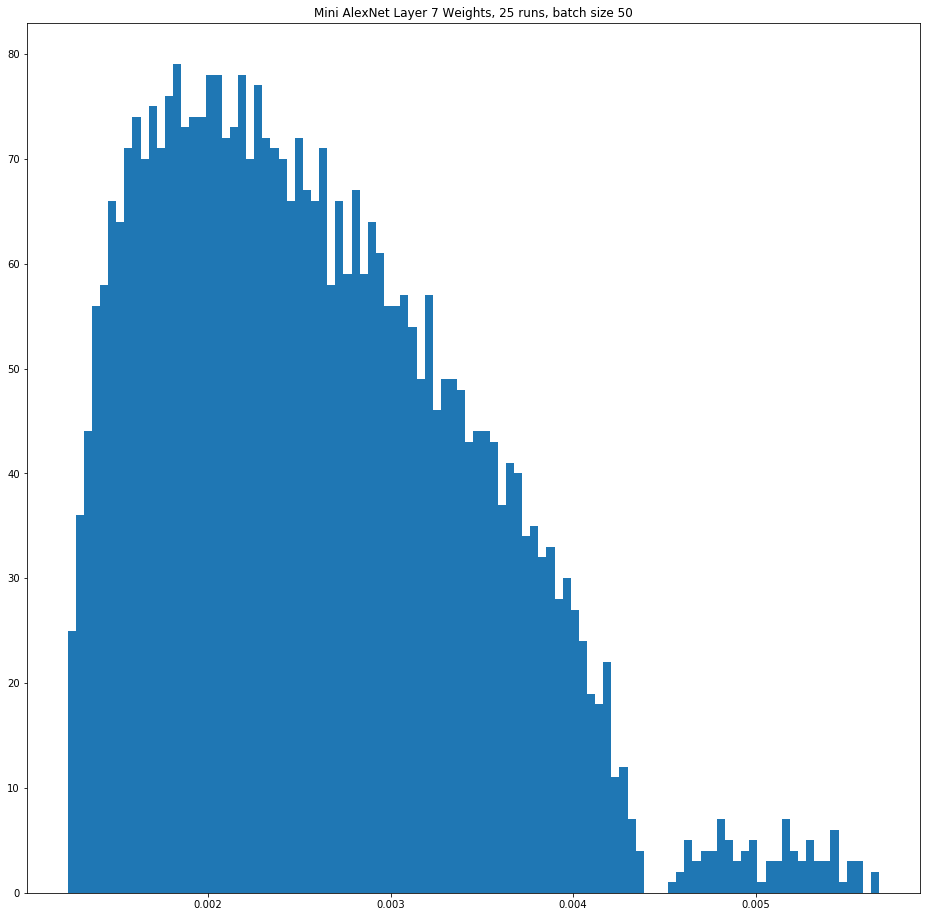

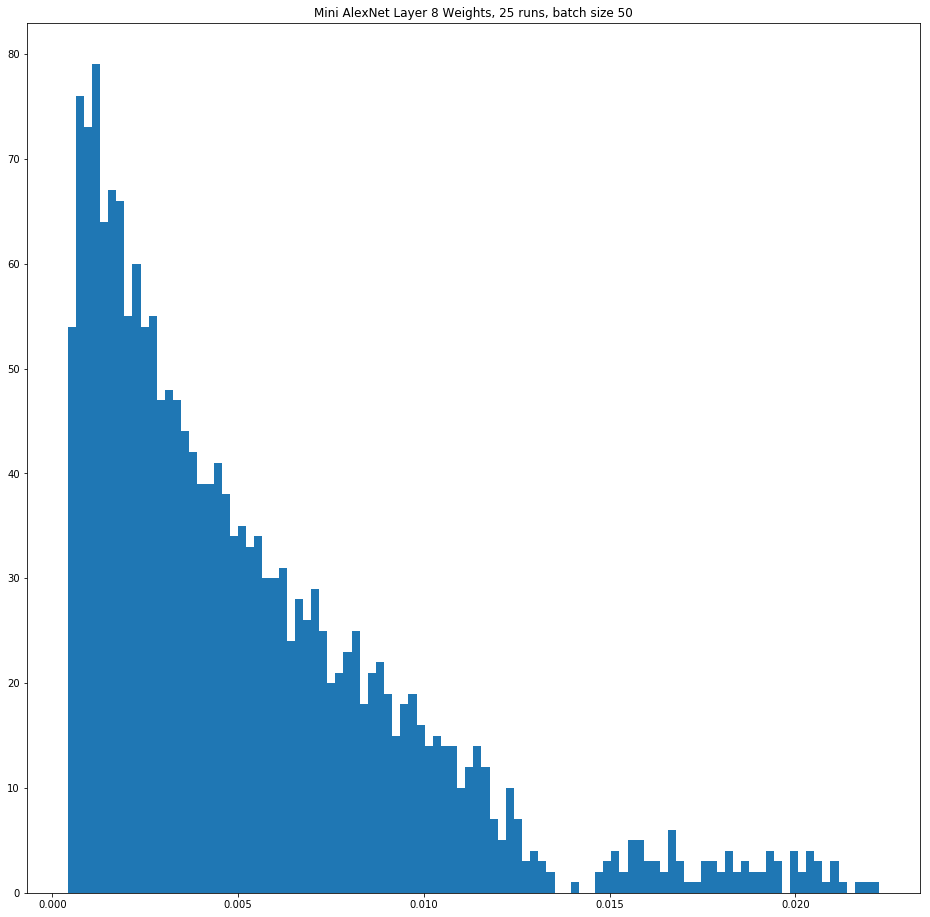

In [64]:
numids = 10
batch_size = 50
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet Layer 7 Weights, 25 runs, batch size 50")
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet Layer 8 Weights, 25 runs, batch size 50")
plt.show()

(3, 2)

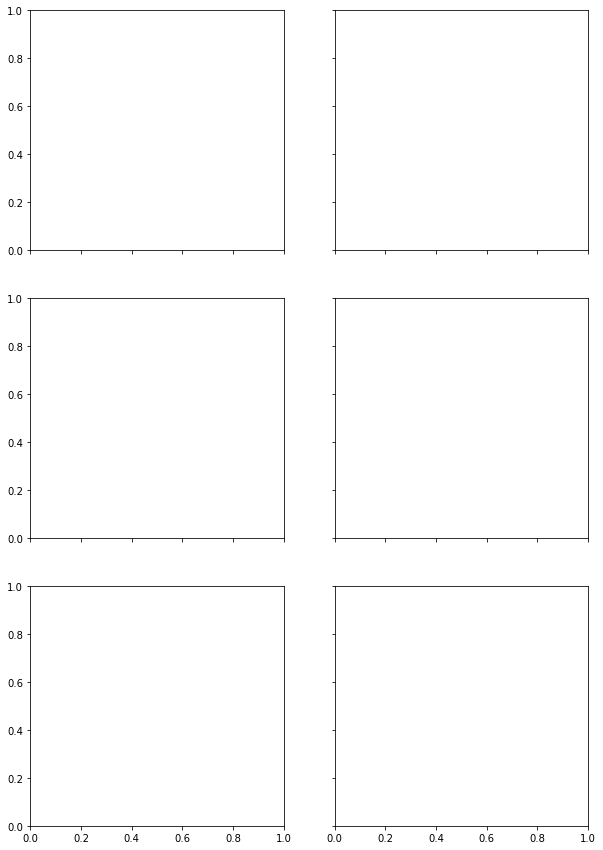

In [65]:
f, axarr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(10, 15))
axarr.shape

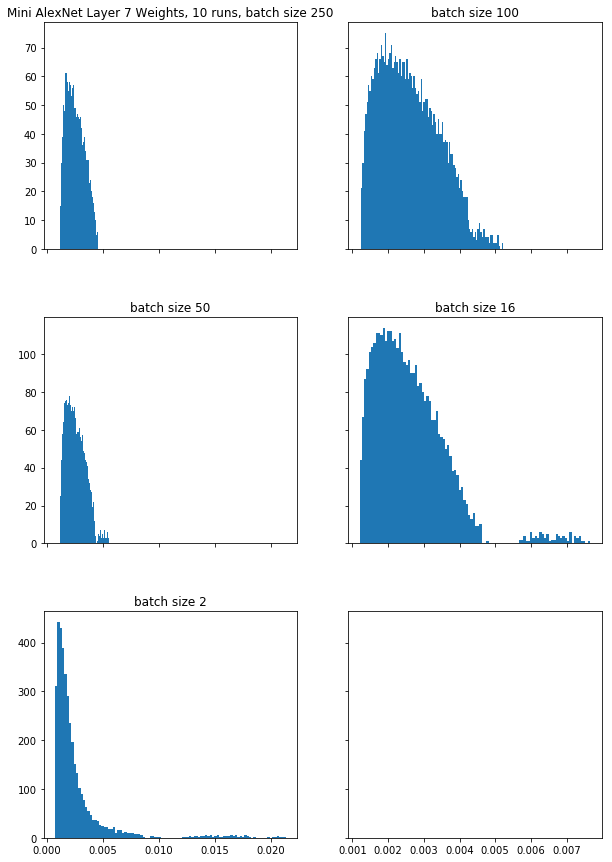

In [66]:
f, axarr = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(10, 15))


numids = 10

batch_size = 250
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
axarr[0,0].hist(ev7s, bins=100);
axarr[0,0].set_title("Mini AlexNet Layer 7 Weights, 10 runs, batch size 250")

batch_size = 100
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
axarr[0,1].hist(ev7s, bins=100);
axarr[0,1].set_title("batch size 100")

batch_size = 50
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
axarr[1,0].hist(ev7s, bins=100);
axarr[1,0].set_title("batch size 50")

batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
axarr[1,1].hist(ev7s, bins=100);
axarr[1,1].set_title("batch size 16")

batch_size = 2
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
axarr[2,0].hist(ev7s, bins=100);
axarr[2,0].set_title("batch size 2")

f.subplots_adjust(hspace=0.3)
plt.show()


In [67]:
pylab.rcParams['figure.figsize'] = 4,4

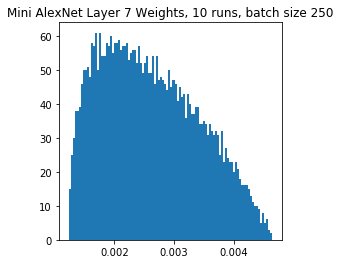

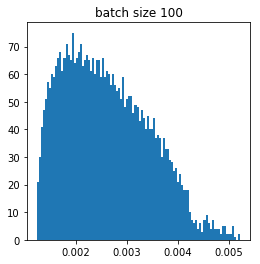

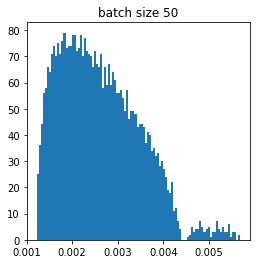

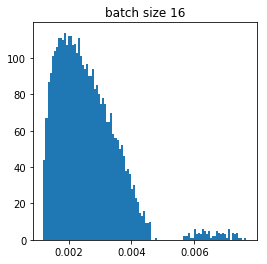

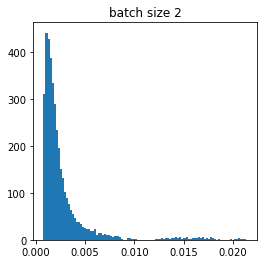

In [68]:


numids = 10

batch_size = 250
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet Layer 7 Weights, 10 runs, batch size 250")
plt.show()


batch_size = 100
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev7s, bins=100);
plt.title("batch size 100")
plt.show()


batch_size = 50
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev7s, bins=100);
plt.title("batch size 50")
plt.show()


batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev7s, bins=100);
plt.title("batch size 16")
plt.show()


batch_size = 2
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev7s, bins=100);
plt.title("batch size 2")
plt.show()


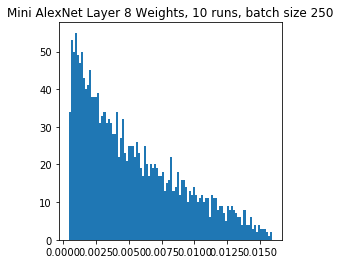

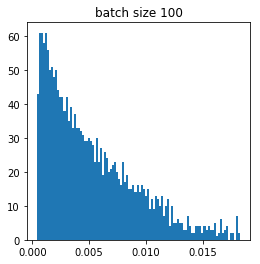

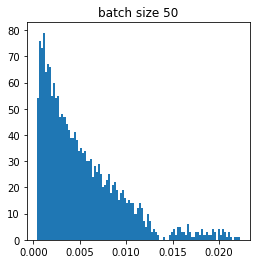

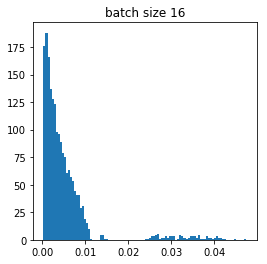

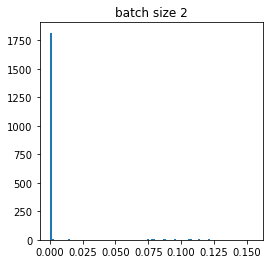

In [69]:
numids = 10

batch_size = 250
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet Layer 8 Weights, 10 runs, batch size 250")
plt.show()


batch_size = 100
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev8s, bins=100);
plt.title("batch size 100")
plt.show()


batch_size = 50
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev8s, bins=100);
plt.title("batch size 50")
plt.show()


batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev8s, bins=100);
plt.title("batch size 16")
plt.show()


batch_size = 2
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)
plt.hist(ev8s, bins=100);
plt.title("batch size 2")
plt.show()


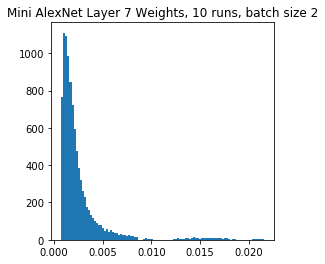

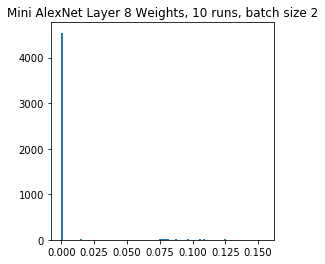

In [70]:
numids = 25
batch_size = 2
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet Layer 7 Weights, 10 runs, batch size 2")
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet Layer 8 Weights, 10 runs, batch size 2")
plt.show()

In [71]:
!ls weights/alexnet.b50.id*

weights/alexnet.b50.id1.final.h5  weights/alexnet.b50.id5.final.h5
weights/alexnet.b50.id10.final.h5 weights/alexnet.b50.id6.final.h5
weights/alexnet.b50.id2.final.h5  weights/alexnet.b50.id7.final.h5
weights/alexnet.b50.id3.final.h5  weights/alexnet.b50.id8.final.h5
weights/alexnet.b50.id4.final.h5  weights/alexnet.b50.id9.final.h5


In [72]:
ev7s, ev8s = [], []

ids = range(1,10)
for idx in ids:
    modelfile = "weights/alexnet.b50.id{}.final.h5".format(idx)
    #print(modelfile)
    model.load_weights(modelfile)
    W7 = model.layers[7].get_weights()[0]
    n = 384
    W = W7 / np.linalg.norm(W7)
    WW = np.dot(W.transpose(),W)
    ev, _ = np.linalg.eig(WW)
    ev7s.extend(ev)
    
    W8 = model.layers[8].get_weights()[0]
    n = 192
    W = W8 / np.linalg.norm(W8)
    WW = np.dot(W.transpose(),W)
    ev, _ = np.linalg.eig(WW)
    ev8s.extend(ev)

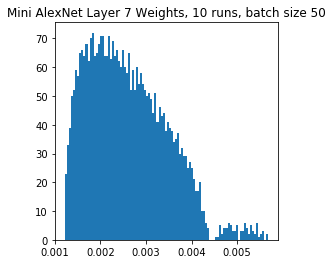

In [73]:
plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet Layer 7 Weights, 10 runs, batch size 50")
plt.show()

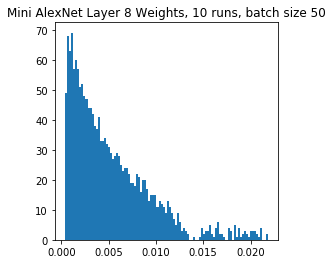

In [74]:
plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet Layer 8 Weights, 10 runs, batch size 50")
plt.show()

### Plot Matrices per Epoch

### Something seems wrong..

weights/alexnet.b16.id1.e10.h5
weights/alexnet.b16.id1.e20.h5
weights/alexnet.b16.id1.e30.h5
weights/alexnet.b16.id1.e40.h5
weights/alexnet.b16.id1.e50.h5
weights/alexnet.b16.id1.e60.h5
weights/alexnet.b16.id1.e70.h5
weights/alexnet.b16.id1.e80.h5
weights/alexnet.b16.id1.e90.h5


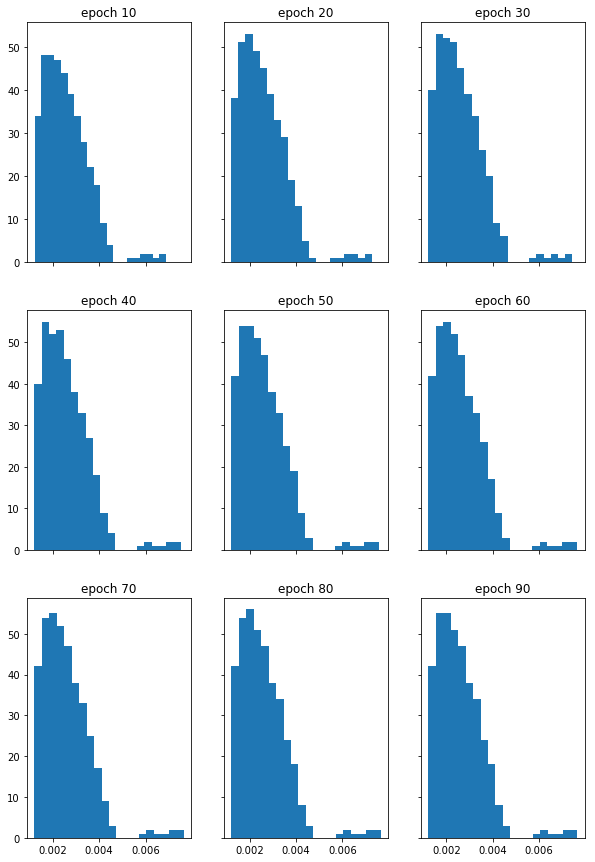

In [98]:
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10, 15))

ev7s, ev8s = [], []

axs = axarr.flatten()
ix = 0
epochs100 = np.arange(10,100, 10)
entropies_w7, entropies_w8 = [], []
for epoch in epochs100:

    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(1,epoch)
    model.load_weights(modelfile)
    print(modelfile)
    W7 = model.layers[7].get_weights()[0]
    n = 384
    W = W7 / np.linalg.norm(W7)
    WW = np.dot(W.transpose(),W)
    ev, _ = np.linalg.eig(WW)

    axs[ix].hist(ev, bins=20);
    axs[ix].set_title("epoch {}".format(epoch))
    ix+=1
    
    ev7s.extend(ev)
    
plt.show()


weights/alexnet.b16.id1.e10.h5
weights/alexnet.b16.id1.e20.h5
weights/alexnet.b16.id1.e30.h5
weights/alexnet.b16.id1.e40.h5
weights/alexnet.b16.id1.e50.h5
weights/alexnet.b16.id1.e60.h5
weights/alexnet.b16.id1.e70.h5
weights/alexnet.b16.id1.e80.h5
weights/alexnet.b16.id1.e90.h5


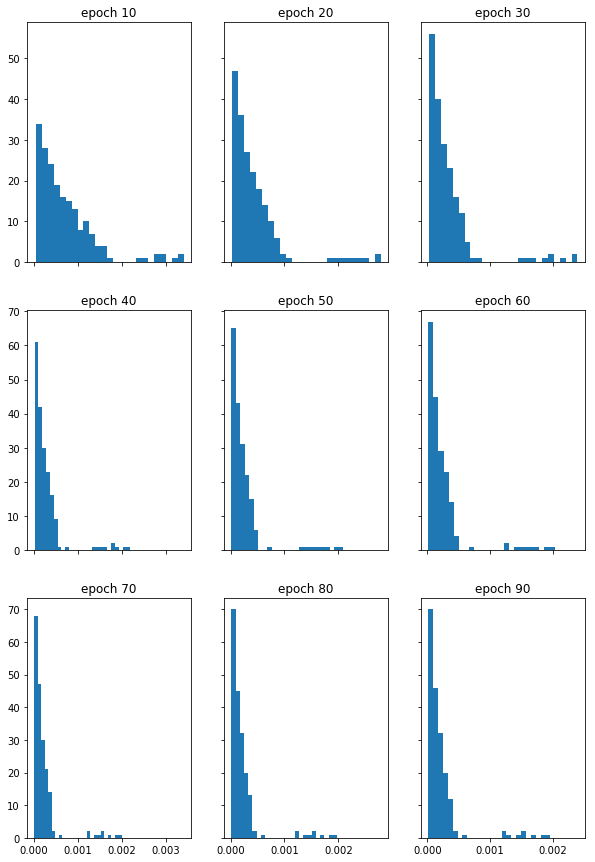

In [108]:
f, axarr = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(10, 15))

ev7s, ev8s = [], []

axs = axarr.flatten()
ix = 0
epochs100 = np.arange(10,100, 10)
entropies_w7, entropies_w8 = [], []
for epoch in epochs100:

    modelfile = "weights/alexnet.b16.id{}.e{}.h5".format(1,epoch)
    model.load_weights(modelfile)
    print(modelfile)
    W8 = model.layers[8].get_weights()[0]
    n = 192
    W = W8 / np.linalg.norm(W7)
    WW = np.dot(W.transpose(),W)
    ev, _ = np.linalg.eig(WW)

    axs[ix].hist(ev, bins=25);
    axs[ix].set_title("epoch {}".format(epoch))
    ix+=1
        
plt.show()


### Random Data

In [122]:
numids = 75
batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

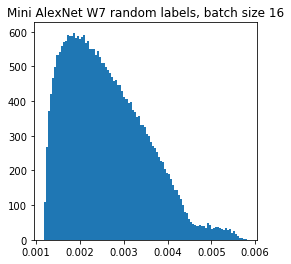

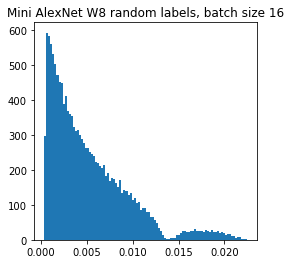

In [130]:
plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size 16")
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size 16")
plt.show()

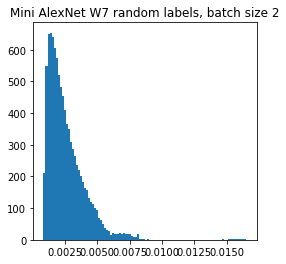

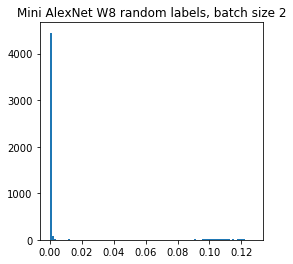

In [132]:
numids = 25
batch_size = 2
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size {}".format(batch_size))
plt.show()


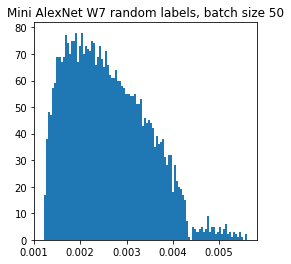

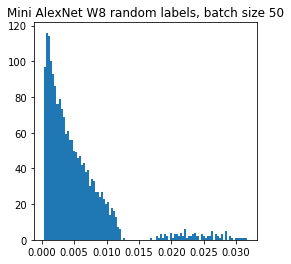

In [139]:
numids = 10
batch_size = 50
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size {}".format(batch_size))
plt.show()


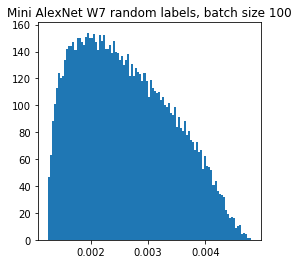

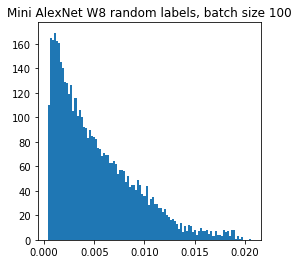

In [134]:
numids = 25
batch_size = 100
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size {}".format(batch_size))
plt.show()


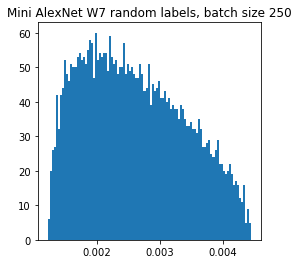

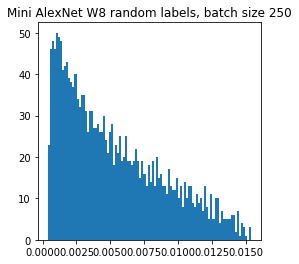

In [136]:
numids = 10
batch_size = 250
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size {}".format(batch_size))
plt.show()


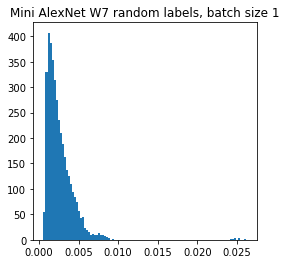

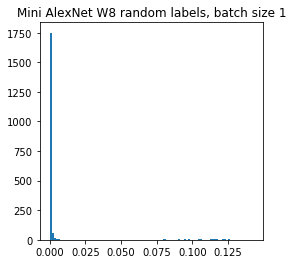

In [137]:
numids = 10
batch_size = 1
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100);
plt.title("Mini AlexNet W7 random labels, batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100);
plt.title("Mini AlexNet W8 random labels, batch size {}".format(batch_size))
plt.show()


### compare random to non random

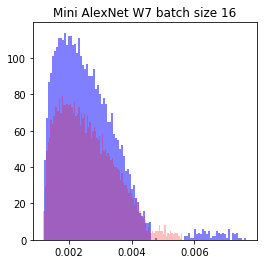

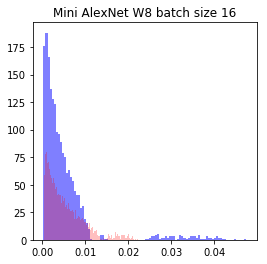

In [143]:
numids = 10
batch_size = 16
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)

ev7s_rand, ev8s_rand = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100, alpha=0.5, color='blue');
plt.hist(ev7s_rand, bins=100, alpha=0.25, color='red');

plt.title("Mini AlexNet W7 batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100, alpha=0.5,  color='blue');
plt.hist(ev8s_rand, bins=100, alpha=0.25,  color='red');
plt.title("Mini AlexNet W8 batch size {}".format(batch_size))
plt.show()


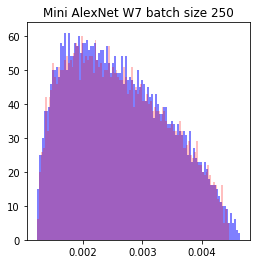

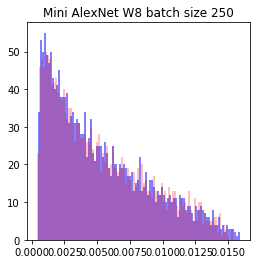

In [147]:
numids = 10
batch_size = 250
ev7s, ev8s = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size)

ev7s_rand, ev8s_rand = alexnet_eigenvalues(idstart=1, numids=numids, batch_size=batch_size, rand=True)

plt.hist(ev7s, bins=100, alpha=0.5, color='blue');
plt.hist(ev7s_rand, bins=100, alpha=0.25, color='red');

plt.title("Mini AlexNet W7 batch size {}".format(batch_size))
plt.show()

plt.hist(ev8s, bins=100, alpha=0.5,  color='blue');
plt.hist(ev8s_rand, bins=100, alpha=0.25,  color='red');
plt.title("Mini AlexNet W8 batch size {}".format(batch_size))
plt.show()
